# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
RANDOM_STATE = 42

### Подгружаем данные

По условиям задания, данные уже разделены на train и test. В практике генеральная совокупность данных делиться на следующие выборки:
  <ul>
   <li><b>DEV</b> - выборка для разработки модели</li>
   <li><b>OOT</b> (out of time) - максимально свежие данные, предназанченные для тестирвования/валидации с целью понимания, что было бы если бы мы модель использовали сейчас.</li>
   <li><b>OOS</b> (out of samle) - выборка предназанченная для тестирования/валидации, совпадающая по временому горизонту с выборкой для разработки. Формирование выборки OOS произовдится со стратификацией уровня дефолта относительно DEV</li>
  </ul>
<p><img src="https://dsbattle.com/assets/images/dev-oos-oot.png" width="700" alt="lorem"></p>

<i>Стратификация — метод выбора подмножества объектов из генеральной совокупности, разбитой на подмножества (страты). При стратификации объекты выбираются таким образом, чтобы итоговая выборка сохраняла соотношения размеров страт.</i>

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv

--2020-10-16 10:30:16--  https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  33.0MB/s    in 0.2s    

2020-10-16 10:30:16 (33.0 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2020-10-16 10:30:16--  https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28K) [text/plain]
Saving to: ‘

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

Семплы и размеры выборок

In [ ]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0


In [ ]:
train_df.shape

(32395, 37)

In [ ]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [ ]:
test_df.shape

(200, 36)

Уровень дефолт-рейта в выборке = 6,4547%

In [ ]:
train_df['default_12m'].values.mean()

0.06454699799351751

PD модель должна возвращать ожидаемый уровень дефолта, чтобы избежать переоценки или недооценки кредитного риска. Для этого делается калибровка модели (в текущем задании это делать не нужно). Бывает два типа калибровки:
  <ul>
   <li><b>TTC</b> (through the cycle) - модель калибруется на среднее значение PD за полный экономический цикл, чтобы в долгосрочной перспективе адекватно оценивать риск, независимо от стадии экономического цикла.</li>
   <li><b>PIT</b> (point in time) - модель калибруется на текущий уровень дефолта (обычно за полседний доступный год), чтобы адекватно оценивать рисккраткосрочной перспективе в текущей стадии экономического цикла.</li>
  </ul>

  <p><img src="https://dsbattle.com/assets/images/calib.png" width="700" alt="lorem"></p>

### Сгенерируем новые относительные признаки 

Объединим обучающую и тестовую выборки для того, чтобы сгенерировать новые признаки сразу для всех выборок

In [ ]:
df = pd.concat([train_df, test_df], sort=False)

In [ ]:
TL = df.ab_long_term_liabilities + df.ab_other_borrowings + df.ab_short_term_borrowing
TA = df.ab_own_capital + df.ab_borrowed_capital
STD = df.ab_short_term_borrowing
STFD = df.ab_short_term_borrowing
CA = df.ab_mobile_current_assets
FCA = df.ab_mobile_current_assets - df.ab_inventory
GY = df.ar_sale_profit

df['r_1_a'] =  df.ar_revenue / (df.ab_accounts_receivable/12) 
df['r_2_a'] = df.ar_sale_cost / (df.ab_inventory/12)
df['r_3_a'] = df.ar_selling_expenses / (df.ar_total_expenses/12)
df['r_4_a'] = df.ar_revenue / TA -TL
df['r_5_a'] = df.ar_revenue / (df.ab_immobilized_assets/12)
df['r_6_a'] = df.ar_revenue / (df.ab_mobile_current_assets + df.ab_cash_and_securities)
df['r_7_a'] = df.ar_sale_profit / df.ar_revenue
df['r_8_a'] = df.ar_profit_before_tax / df.ar_revenue
df['r_9_a'] = df.ar_net_profit / df.ar_revenue

df['r_10_a'] = df.ab_short_term_borrowing / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_11_a'] = df.ab_accounts_payable / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_12_a'] = df.ab_inventory / df.ar_revenue
df['r_13_a'] = df.ab_long_term_liabilities / df.ar_revenue
df['r_15_a'] = df.ar_taxes / df.ar_revenue

df['r_16_a'] = df.ab_inventory / df.ab_borrowed_capital
df['r_17_a'] = df.ab_inventory / df.ab_mobile_current_assets
df['r_18_a'] = df.ab_inventory / df.ab_accounts_payable

df['r_19_a'] = df.ab_accounts_receivable / (df.ab_cash_and_securities + df.ab_accounts_receivable)
df['r_20_a'] = df.ab_cash_and_securities / df.ab_borrowed_capital
df['r_21_a'] = df.ab_cash_and_securities / df.ab_short_term_borrowing
df['r_22_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable)
df['r_23_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable + df. ab_other_borrowings)

df['r_24_a'] = df.ar_profit_before_tax / df.ar_net_profit

df['r_25_a'] = TL / TA
df['r_26_a'] = (df.ab_accounts_receivable + df.ab_cash_and_securities) / TA
df['r_27_a'] = CA / STD


все абсолютные признаки убираем кроме чистой прибыли, оставляем только относительные признаки

Также убираем признак ul_systematizing_flg так как у нее единственное значение на всей выборке

In [ ]:
df_short = df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
         'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
         'ar_other_profit_and_losses', 'ul_systematizing_flg'], axis = 1)

Преобразуем категориальный признак 'ul_staff_range'. В данном случае можно категории просто заменить на числа,сохраняя порядок, так как для категорий данного признака поряд задан.

In [ ]:
df_short['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [ ]:
df_short.loc[df_short['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
df_short.loc[df_short['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2
df_short.loc[df_short['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

Разбиваем на трейн и тест назад


In [ ]:
test_df_new = df_short.iloc[-200:,:]

In [ ]:
train_df_new = df_short.iloc[:-200, :]

Существует два подоха к выбору объекта оценки:
  <ul>
   <li><b>Розничный</b> (портфельный) - моделирование проводится на уровне кредитного требования (кредита).</li>
   <li><b>Корпоративный</b> (индивидуальный) - моделирование проводится на уровне субъекта (клиента).</li>
  </ul>
В текущем задании применим корпоративный подход и выполним моделирование на уровне клиента. Дубликаты с разным record_id, но одинаковыми остальными значениями признаков. Удаляем их из трейна

In [ ]:
column_list = list(train_df_new.columns)
subset = column_list.copy()
subset.remove('record_id')

train_df_new.drop_duplicates(subset=subset, inplace = True)
train_df_new.drop(['record_id'], axis = 1, inplace = True)

Разбиваем на 2 выборки по наличию финансовой отчетности

In [ ]:
train_df_ip = train_df_new[train_df_new['ar_net_profit'].isnull()]
train_df_phys = train_df_new[~train_df_new['ar_net_profit'].isnull()]

In [ ]:
train_df_ip.shape

(10215, 51)

In [ ]:
train_df_phys.shape

(16375, 51)

Удалим столбцы в которых есть пропуски для данных без фин отчетности

In [ ]:
nan_colmn_ip = train_df_ip.columns[train_df_ip.isnull().any()]

In [ ]:
train_df_ip.drop(nan_colmn_ip, axis = 1, inplace = True)

Пропуски в таблице с фин отчетностью только в новых признаках. Заполним их нулями, вероятно мы где-то поделили на ноль.

In [ ]:
train_df_phys.fillna(0, inplace = True)

### Модель для данных без фин отчетности

Разобьем данные на тестовую и обучающую выборки

In [ ]:
X_ip = train_df_ip.drop(['default_12m'], axis = 1)
y_ip = train_df_ip['default_12m']

In [ ]:
X_ip['ul_strategic_flg'].value_counts()

0    10215
Name: ul_strategic_flg, dtype: int64

Удаляем этот признак, так как он является константым для данных без фин отчетности. \\
Особенности работы библиотеки  riskpy, которая будет использоваться дальше для бинаризации, требует чтобы данные имели тип данных, занимающий <= количество бит чем float32


In [ ]:
X_ip.drop(['ul_strategic_flg'], axis = 1, inplace = True)
X_ip['ul_capital_sum'] = X_ip['ul_capital_sum'].astype(int)
X_ip['ul_staff_range'] = X_ip['ul_staff_range'].astype(int)
y_ip = y_ip.astype(int)

Разбиваем размеченные данные на обучающую и валидационную выборки

In [ ]:
X_train_ip, X_test_ip, y_train_ip, y_test_ip = train_test_split(X_ip, y_ip, test_size=0.3, random_state=42)

### WOE
Для бинаризации признаков будет использовать библиотеку riskpy


In [ ]:
!pip install git+https://github.com/Falconwatch/riskpy.git@master

  Cloning https://github.com/Falconwatch/riskpy.git (to revision master) to /tmp/pip-req-build-avq64nl1
  Running command git clone -q https://github.com/Falconwatch/riskpy.git /tmp/pip-req-build-avq64nl1
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Created wheel for riskpy: filename=riskpy-0.0.4-cp36-none-any.whl size=31781 sha256=184a466f0cd44e3df4530959afa84be427c930310dec9aa9eed74e5d9797c91c
  Stored in directory: /tmp/pip-ephem-wheel-cache-4v104_69/wheels/4b/8b/30/1ff8c31ce3c64eb17909ee4b39a0ab6df6a06f7d2f75caabea
Successfully built riskpy


In [ ]:
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

Для работы библиотеки riskpy необходимо добавить таргет в данные

In [ ]:
X_train_ip['default_12m'] = y_train_ip
X_test_ip['default_12m'] = y_test_ip
X_ip['default_12m'] = y_ip

In [ ]:
binner_ip = Binner()
bins = binner_ip.fit(X_train_ip, 'default_12m')
X_train_woe_ip = binner_ip.transform(X_train_ip)
X_test_woe_ip = binner_ip.transform(X_test_ip)

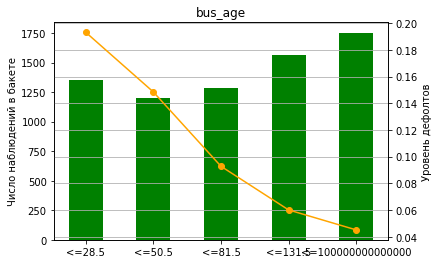

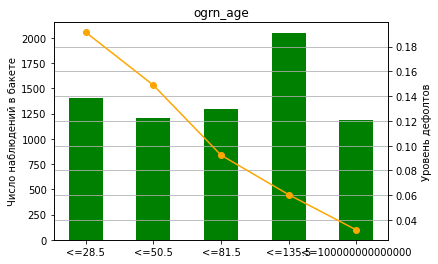

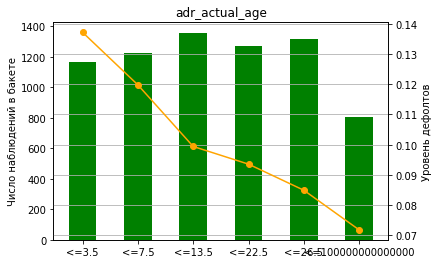

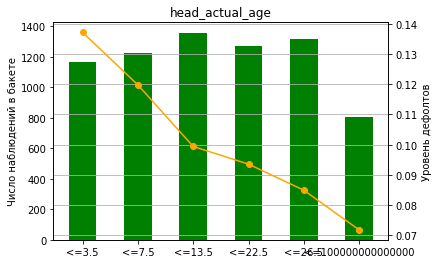

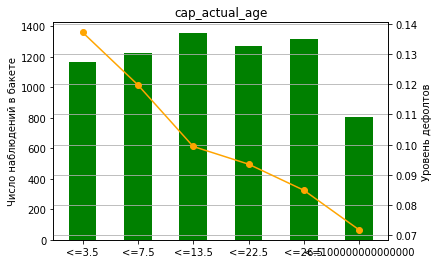

No binning for variable ul_staff_range


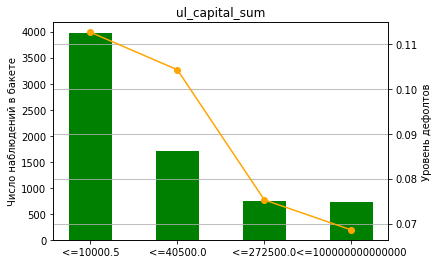

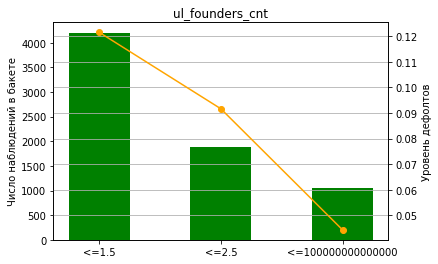

No binning for variable ul_branch_cnt


In [ ]:
binning_barchart(bins)

### Отбор признаков


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

Экспериментально было подобрано, что 4 признака в данной задаче для данных без фин отчетности является оптимальным и позволяет убрать все коррелирующие признаки

In [ ]:
FEATURE_COUNT = 4
N_SPLITS = 3

In [ ]:
y_train_woe_ip = X_train_woe_ip['default_12m']
y_test_woe_ip = X_test_woe_ip['default_12m']
X_train_woe_ip.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_ip.drop(['default_12m'], axis = 1, inplace = True)

Запустим метод  Forward Selection для отбора признаков.

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT , 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_ip, y_train_woe_ip)

Выведем отобранные признаки

In [ ]:
selector.subsets_[4]

{'avg_score': 0.700473822683326,
 'cv_scores': array([0.68657404, 0.7199425 , 0.69490493]),
 'feature_idx': (1, 2, 5, 6),
 'feature_names': ('ogrn_age_woe',
  'adr_actual_age_woe',
  'ul_capital_sum_woe',
  'ul_founders_cnt_woe')}

Построим карту корреляций для выбранных признаков.

In [ ]:
top_feat = list(selector.subsets_[FEATURE_COUNT]['feature_names'])
X_train_woe_ip[top_feat].corr()

,ogrn_age_woe,adr_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe
ogrn_age_woe,1.000000,0.150301,0.074962,0.061599
adr_actual_age_woe,0.150301,1.000000,-0.064346,-0.017928
ul_capital_sum_woe,0.074962,-0.064346,1.000000,0.078222
ul_founders_cnt_woe,0.061599,-0.017928,0.078222,1.000000


Все корреляции меньше 0.5. <br>Эффективность моделей бинарной классификации наилучшим образом оценивает метрика ROC/AUC (<b>Gini</b>). Поэтому оценим значимость каждого признака, вычислив коэффициент <b>Gini</b>.

In [ ]:
gini_features = pd.DataFrame(index=top_feat, columns = ['Gini'])
for feat in top_feat:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_ip.loc[:, feat].values.reshape(-1,1), y_train_woe_ip)
    preds_train = logreg.predict_proba(X_train_woe_ip.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_ip, preds_train) - 1

In [ ]:
gini_features

,Gini
ogrn_age_woe,0.345307
adr_actual_age_woe,0.125302
ul_capital_sum_woe,0.0807512
ul_founders_cnt_woe,0.144248


In [ ]:
X_train_woe_ip_final = X_train_woe_ip[top_feat]
X_test_woe_ip_final = X_test_woe_ip[top_feat]

### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_ip_final, y_train_woe_ip):
        
        X_train, X_test = X_train_woe_ip_final.iloc[train_index,:], X_train_woe_ip_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_ip.iloc[train_index], y_train_woe_ip.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

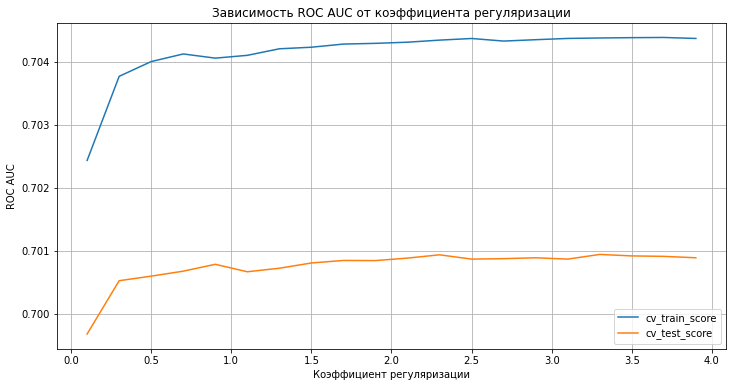

In [ ]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [ ]:
print("Наилучший коэффициент L2 - регуляризации:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент L2 - регуляризации: 3.3000000000000007


### Строим Лассо регрессию

Обучаем модель на всей обучащей выборке (без валидации)

In [ ]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.3)
logreg_ip.fit(X_train_woe_ip_final, y_train_woe_ip)
y_pred = logreg_ip.predict_proba(X_test_woe_ip_final)[:,1]
y_pred_train = logreg_ip.predict_proba(X_train_woe_ip_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_ip, y_pred))
print("ROC AUC train:", roc_auc_score(y_train_woe_ip, y_pred_train))

ROC AUC val: 0.7000789521818355
ROC AUC train: 0.7039632469355575


### Модель для данных с фин отчетностью

Проделаем аналогичные действия для данных с фин отчетностью.

In [ ]:
train_df_phys['ul_strategic_flg'].value_counts()

0    16372
1        3
Name: ul_strategic_flg, dtype: int64

Убираем ul_strategic_flg так как практически константная переменная, убираем ul_branch_cnt так как не биннаризуется

In [ ]:
train_df_phys.drop(['ul_strategic_flg', 'ul_branch_cnt'], axis = 1, inplace = True)

In [ ]:
train_df_phys = train_df_phys.astype('float32')
train_df_phys = train_df_phys.replace([np.inf, -np.inf], 0)
X_phys = train_df_phys.drop(['default_12m'], axis = 1)
y_phys = train_df_phys['default_12m']

Разделяем данные на обучающую и валидационную выборки

In [ ]:
X_train_phys, X_test_phys, y_train_phys, y_test_phys = train_test_split(X_phys, y_phys, test_size=0.3, random_state=42)

In [ ]:
X_train_phys['default_12m'] = y_train_phys
X_test_phys['default_12m'] = y_test_phys

Проводим бинаризацию признаков

In [ ]:
binner_phys = Binner()
bins = binner_phys.fit(X_train_phys, 'default_12m')
X_train_woe_phys = binner_phys.transform(X_train_phys)
X_test_woe_phys = binner_phys.transform(X_test_phys)

Выведем результат бинаризации

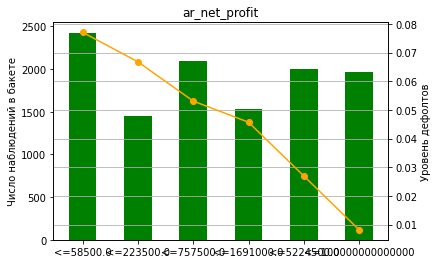

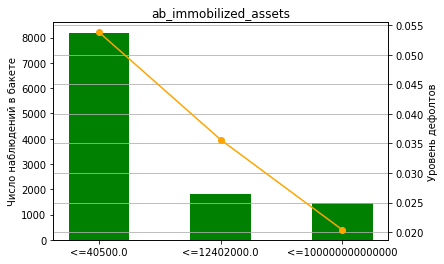

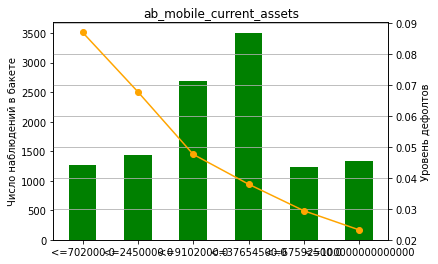

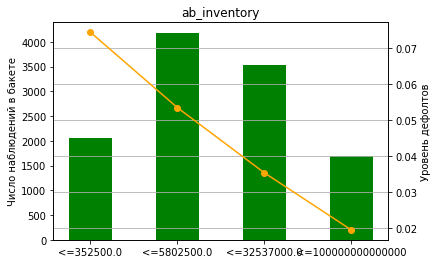

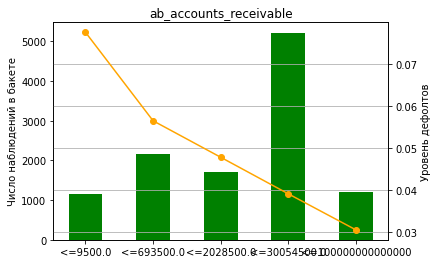

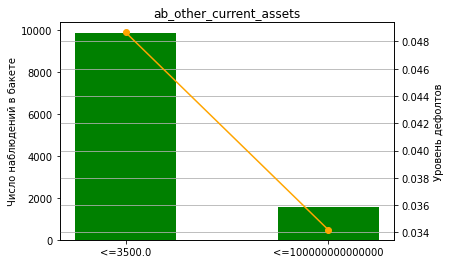

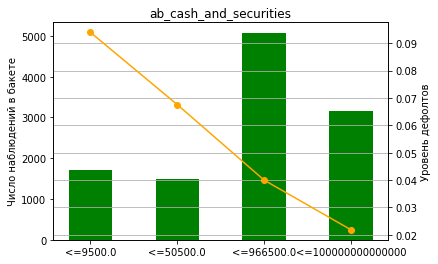

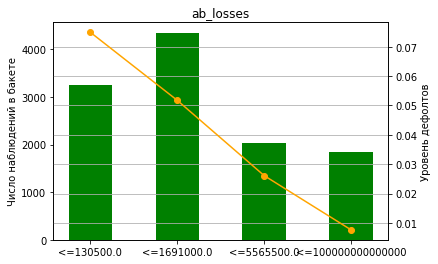

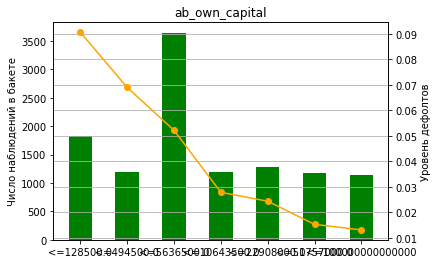

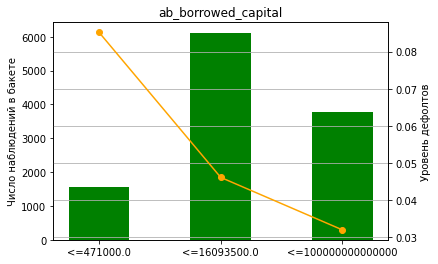

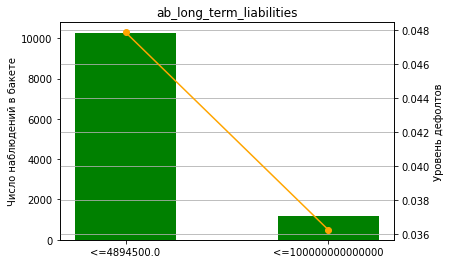

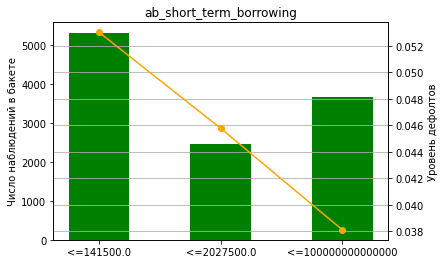

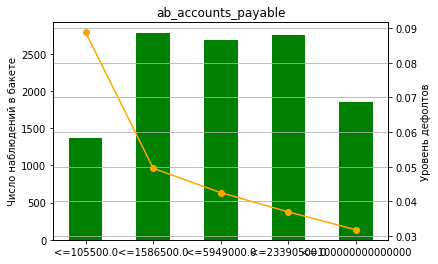

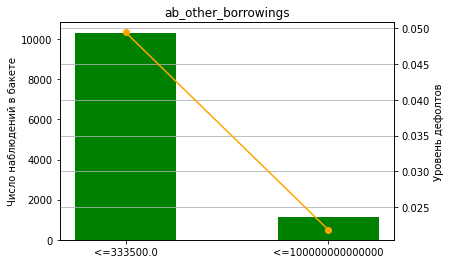

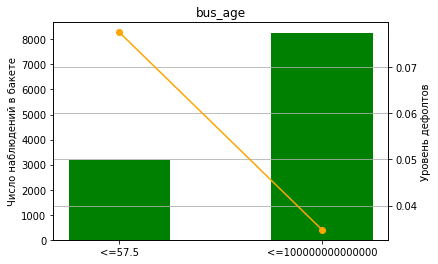

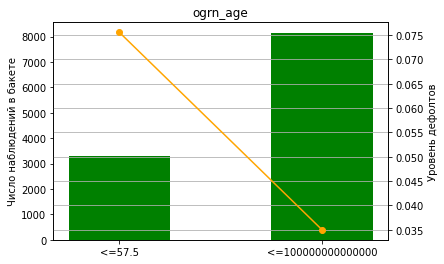

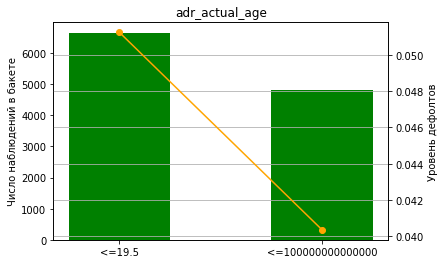

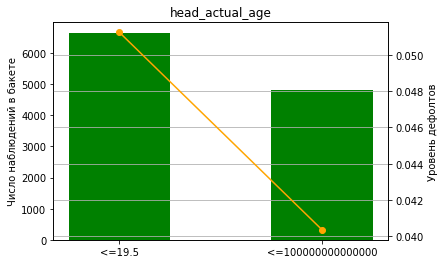

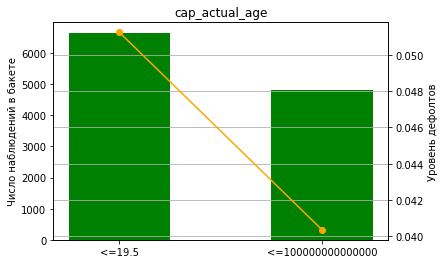

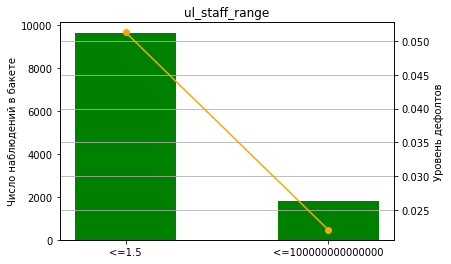

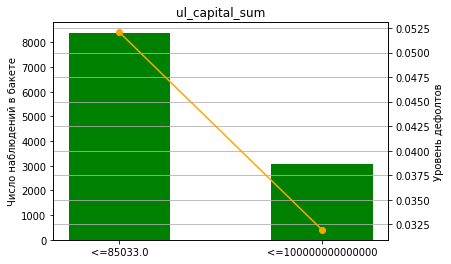

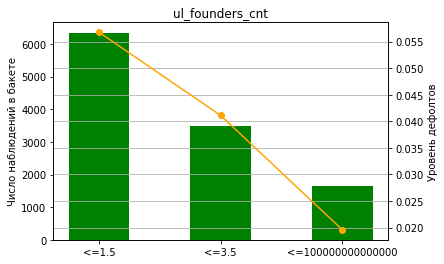

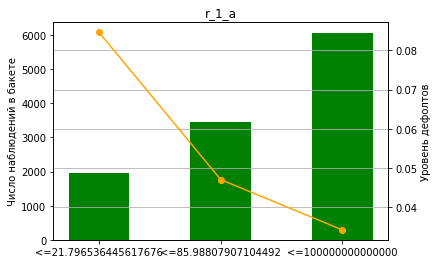

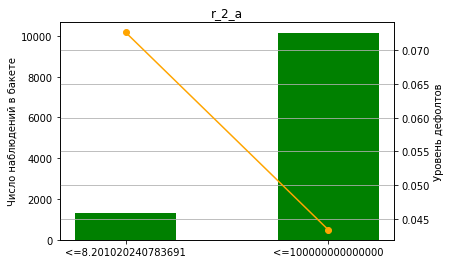

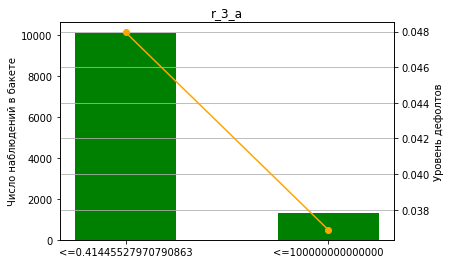

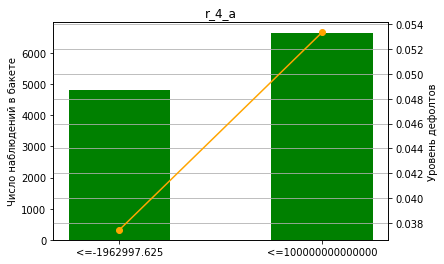

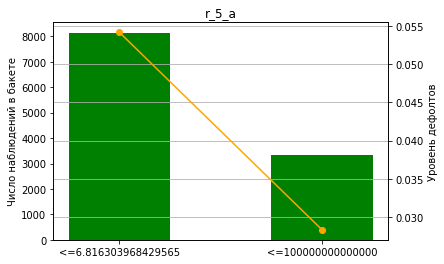

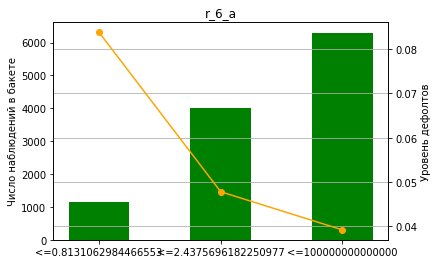

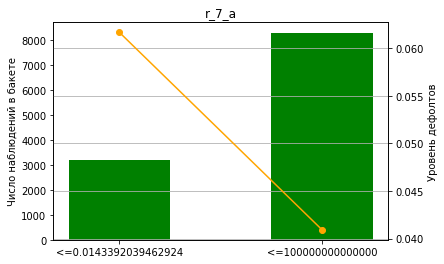

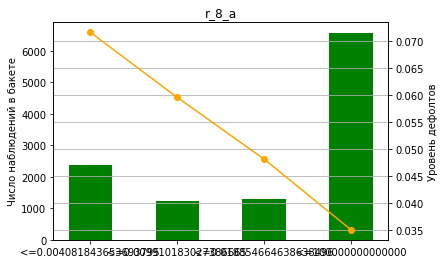

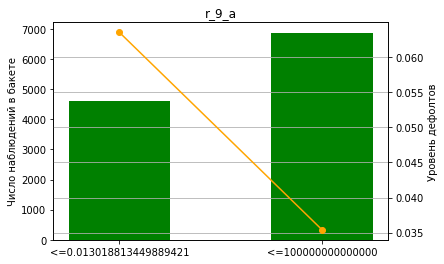

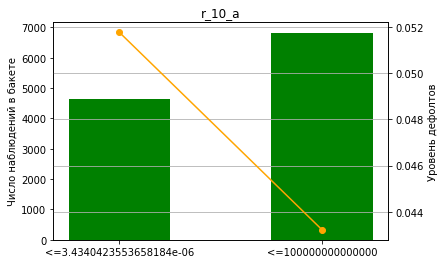

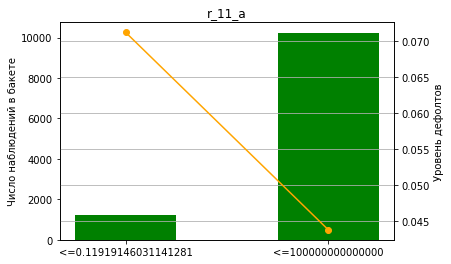

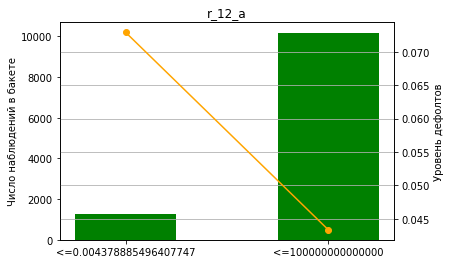

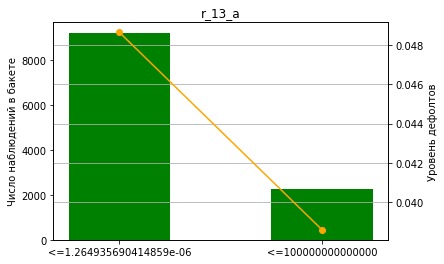

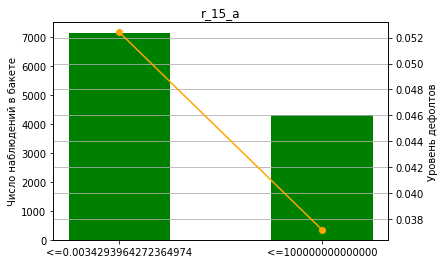

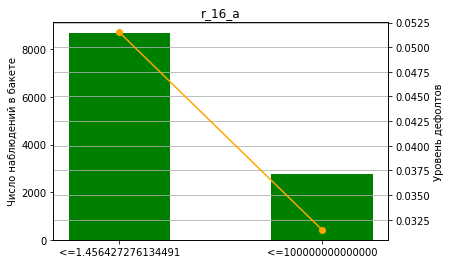

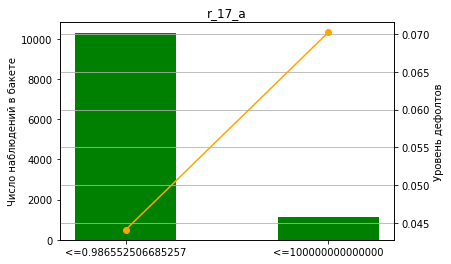

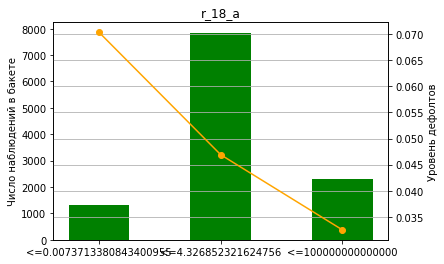

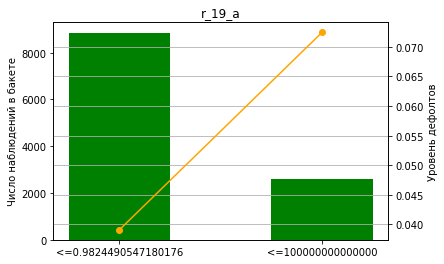

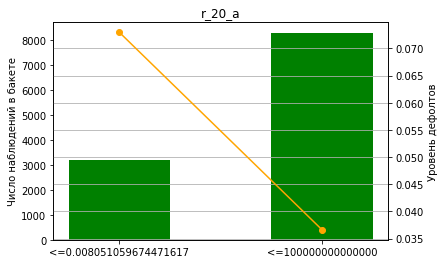

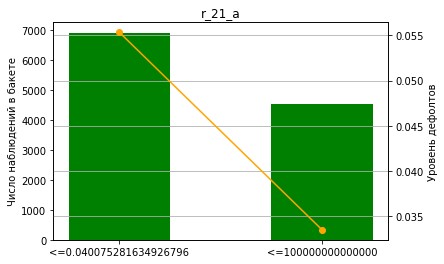

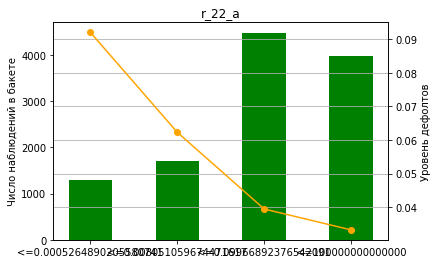

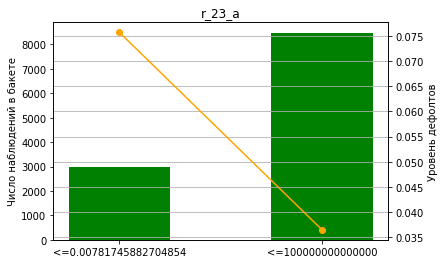

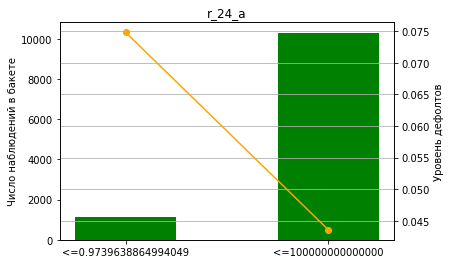

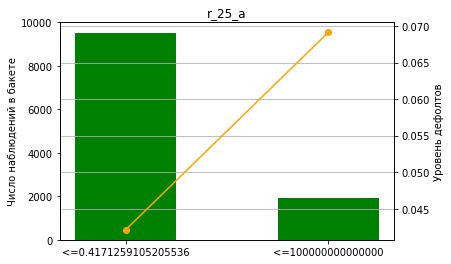

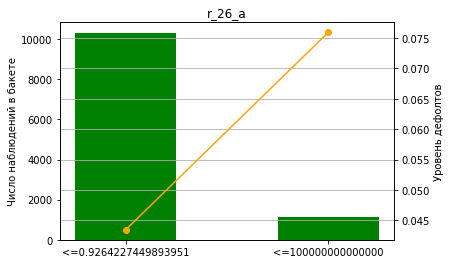

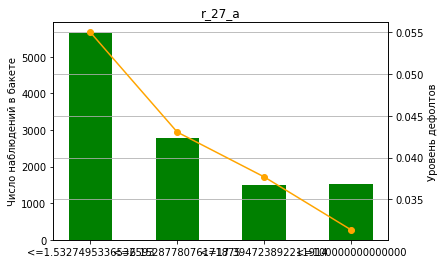

In [ ]:
binning_barchart(bins)

### Отбор признаков

In [ ]:
FEATURE_COUNT = 12

In [ ]:
y_train_woe_phys = X_train_woe_phys['default_12m']
y_test_woe_phys = X_test_woe_phys['default_12m']
X_train_woe_phys.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_phys.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT, 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_phys, y_train_woe_phys)

Выведем отобранные признаки:

In [ ]:
selector.subsets_[FEATURE_COUNT]

{'avg_score': 0.7208475458818128,
 'cv_scores': array([0.72798687, 0.71812943, 0.71642634]),
 'feature_idx': (0, 6, 8, 10, 14, 16, 21, 22, 23, 24, 27, 39),
 'feature_names': ('ar_net_profit_woe',
  'ab_cash_and_securities_woe',
  'ab_own_capital_woe',
  'ab_long_term_liabilities_woe',
  'bus_age_woe',
  'adr_actual_age_woe',
  'ul_founders_cnt_woe',
  'r_1_a_woe',
  'r_2_a_woe',
  'r_3_a_woe',
  'r_6_a_woe',
  'r_19_a_woe')}

In [ ]:
top_feat_phys = list(selector.subsets_[FEATURE_COUNT]['feature_names'])

Построим карту корреляций выбранных признаков. Проверим, чтобы между любыми двумя признаками не было высокой корреляции

In [ ]:
X_train_woe_phys[top_feat_phys].corr()

,ar_net_profit_woe,ab_cash_and_securities_woe,ab_own_capital_woe,ab_long_term_liabilities_woe,bus_age_woe,adr_actual_age_woe,ul_founders_cnt_woe,r_1_a_woe,r_2_a_woe,r_3_a_woe,r_6_a_woe,r_19_a_woe
ar_net_profit_woe,1.000000,0.356387,0.702859,0.292458,0.244550,-0.026971,0.248271,0.182714,0.141222,0.053478,0.059143,0.012449
ab_cash_and_securities_woe,0.356387,1.000000,0.383771,0.156322,0.131458,0.001075,0.159804,0.226888,0.173492,0.056466,0.094336,0.476009
ab_own_capital_woe,0.702859,0.383771,1.000000,0.328376,0.446935,-0.029675,0.391417,0.242669,0.194044,0.048229,-0.014835,-0.005739
ab_long_term_liabilities_woe,0.292458,0.156322,0.328376,1.000000,0.126417,-0.038247,0.235187,0.109226,0.055271,0.117492,-0.040454,0.013717
bus_age_woe,0.244550,0.131458,0.446935,0.126417,1.000000,0.009713,0.218212,0.143217,0.135622,-0.039760,0.044573,0.003620
adr_actual_age_woe,-0.026971,0.001075,-0.029675,-0.038247,0.009713,1.000000,-0.069423,0.053520,0.020720,-0.014622,0.044221,0.002103
ul_founders_cnt_woe,0.248271,0.159804,0.391417,0.235187,0.218212,-0.069423,1.000000,0.169636,0.072415,0.005893,-0.040182,0.063644
r_1_a_woe,0.182714,0.226888,0.242669,0.109226,0.143217,0.053520,0.169636,1.000000,0.282926,0.063226,0.436665,0.076665
r_2_a_woe,0.141222,0.173492,0.194044,0.055271,0.135622,0.020720,0.072415,0.282926,1.000000,0.050192,0.435531,0.005639
r_3_a_woe,0.053478,0.056466,0.048229,0.117492,-0.039760,-0.014622,0.005893,0.063226,0.050192,1.000000,0.082342,-0.025094


Так как признак ab_own_capital сильно коррелирует с ar_net_profit, то удалим один из них

In [ ]:
top_feat_phys.remove('ab_own_capital_woe')

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

Посчитаем коэффициент Джини для выбранных признаков

In [ ]:
gini_features = pd.DataFrame(index=top_feat_phys, columns = ['Gini'])
for feat in top_feat_phys:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1), y_train_woe_phys)
    preds_train = logreg.predict_proba((X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1)))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_phys, preds_train) - 1

In [ ]:
gini_features

,Gini
ar_net_profit_woe,0.304293
ab_cash_and_securities_woe,0.282631
ab_long_term_liabilities_woe,0.024321
bus_age_woe,0.193761
adr_actual_age_woe,0.05964
ul_founders_cnt_woe,0.146252
r_1_a_woe,0.190859
r_2_a_woe,0.0666522
r_3_a_woe,0.0255522
r_6_a_woe,0.120578


Признаки с Джини < 5% удаляем, так как у них низкая предсказательная способность.

In [ ]:
top_feat_phys.remove('ab_long_term_liabilities_woe')
top_feat_phys.remove('r_3_a_woe')

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_phys_final, y_train_woe_phys):
        
        X_train, X_test = X_train_woe_phys_final.iloc[train_index,:], X_train_woe_phys_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_phys.iloc[train_index], y_train_woe_phys.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

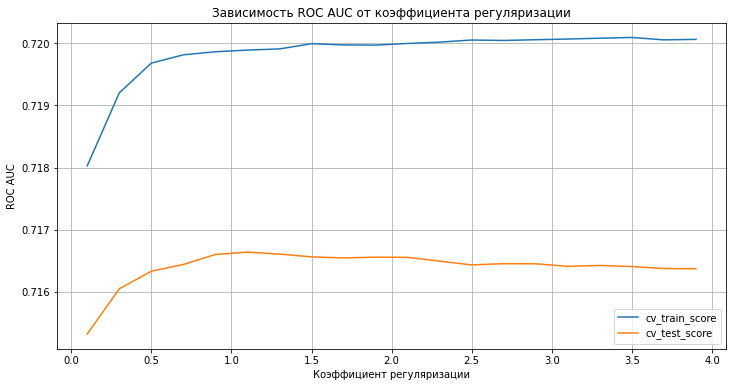

In [ ]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [ ]:
print("Наилучший коэффициент регуляризации из рассмотренных:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент регуляризации из рассмотренных: 1.1000000000000003


Обучаем финальную модель на всех обучающих данных (без валидации)

In [ ]:
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.1)
logreg_phys.fit(X_train_woe_phys_final, y_train_woe_phys)
y_pred = logreg_phys.predict_proba(X_test_woe_phys_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_phys, y_pred))

ROC AUC val: 0.7104574617745694


### Формирование файла с ответом

Разделим тестовые данные на данные с фин отчетностью и без нее:

In [ ]:
test_df_ip = test_df_new[test_df_new['ar_net_profit'].isnull()]
test_df_phys = test_df_new[~test_df_new['ar_net_profit'].isnull()]

In [ ]:
record_id_ip = test_df_ip['record_id']
record_id_phys = test_df_phys['record_id']

Подготовим тестовые данные для WOE трансформации

In [ ]:
test_df_phys = test_df_phys.astype('float32')
test_df_phys = test_df_phys.replace([np.inf, -np.inf], 0)
test_df_phys = test_df_phys.fillna(0)

Применим WOE трансформацию для тестовых данных

In [ ]:
test_df_ip = binner_ip.transform(test_df_ip[X_train_ip.columns])[top_feat]
test_df_phys = binner_phys.transform(test_df_phys[X_train_phys.columns])[top_feat_phys]

###Подбор трешхолда

Так как мы знаем распределение дефолтов/не дефолтов на тестовой выборке (а именно 50/50), то попробуем подобрать порог семплируя из размеченных данных 200 дефолтов и 200 не дефолтов. Для каждого семла будем перебирать пороги от 0.05 до 0.15 c шагом 0.005 и будем запоминать тот, который дает наилучший accuracy. В результате работы функции получится N (количество семлов) порогов. Функция возвращает медиану из N порогов.

In [ ]:
X_ip_with_labels = X_train_woe_ip_final.copy()
X_ip_with_labels['default_12m'] = y_ip
X_phys_with_labels = X_train_woe_phys_final.copy()
X_phys_with_labels['default_12m'] = y_phys

In [ ]:
def find_cutoff(data, model, N):
    cutoff = []
    acc = []
    for i in range(N):
        idx_1 = data[data['default_12m'] == 1].shape[0]
        idx_0 = data[data['default_12m'] == 0].shape[0]
        idx_1 = np.random.randint(0, idx_1, 200)
        idx_0 = np.random.randint(0, idx_0, 200)
    
        data_1 = data[data['default_12m'] == 1].iloc[idx_1,]
        data_0 = data[data['default_12m'] == 0].iloc[idx_0,]
        data_1.drop(['default_12m'], axis = 1, inplace = True)
        data_0.drop(['default_12m'], axis = 1, inplace = True)
    
        pred_1 = model.predict_proba(data_1)[:,1]
        pred_0 = model.predict_proba(data_0)[:,1]
        
        best_acc = 0
        best_cutoff = 0
        for cur_cutoff in np.linspace(0.05, 0.15, 21):
            true_0 = 200 - np.sum(pred_0 > cur_cutoff)
            true_1 = np.sum(pred_1 > cur_cutoff)
            cur_acc = (true_0 + true_1) / 400
            if cur_acc > best_acc:
                best_acc = cur_acc
                best_cutoff = cur_cutoff
        acc.append(best_acc)
        cutoff.append(best_cutoff)
    return np.median(cutoff)

In [ ]:
cutoff_phys = find_cutoff(X_phys_with_labels, logreg_phys, 20)
print("Cutoff с фин отчетностью:", cutoff_phys)

Cutoff с фин отчетностью: 0.05


In [ ]:
cutoff_ip = find_cutoff(X_ip_with_labels, logreg_ip, 20)
print("Cutoff без фин отчетности:", cutoff_ip)

Cutoff без фин отчетности: 0.09999999999999999


Модель для данных без фин отчетности обученная на всех размеченных данных

In [ ]:
X_ip['default_12m'] = y_ip
data_binned_ip = binner_ip.transform(X_ip)

In [ ]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.7)
logreg_ip.fit(data_binned_ip.drop(['default_12m'], axis=1)[top_feat], data_binned_ip['default_12m'])
y_pred_ip = logreg_ip.predict_proba(test_df_ip)[:,1]
predict_ip = (y_pred_ip > cutoff_ip).astype(int)

Модель для данных с фин отчетности обученная на всех размеченных данных

In [ ]:
X_phys['default_12m'] = y_phys
data_binned_phys = binner_phys.transform(X_phys)

In [ ]:
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.5)
logreg_phys.fit(data_binned_phys.drop(['default_12m'], axis=1)[top_feat_phys], 
                data_binned_phys['default_12m'])
y_pred_phys = logreg_phys.predict_proba(test_df_phys)[:,1]
predict_phys = (y_pred_phys > cutoff_phys).astype(int)

Формирование ответа

In [ ]:
ans_ip = dict(zip(record_id_ip, predict_ip))
ans_phys = dict(zip(record_id_phys, predict_phys))
ans_dict = ans_ip.copy()
ans_dict.update(ans_phys)

In [ ]:
answ_df = test_df[['record_id']]
answ_df['predict'] = answ_df['record_id']
answ_df['predict'] = answ_df['predict'].map(ans_dict)
answ_df = answ_df.rename(columns = {'record_id': 'id'})

In [ ]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

[Текст ссылки](https://)Для загрузки своего результата на https://dsbattle.com/hackathons/juniords/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

P.S. еще немного картиночек про то как модель ранжирует объекты

Модель для данных без фин отчетности:

In [ ]:
X_ip_with_labels = X_train_woe_ip_final.copy()
X_ip_with_labels['default_12m'] = y_train_woe_ip
X_ip_1 = X_ip_with_labels[X_ip_with_labels['default_12m'] == 1].iloc[:200,]
X_ip_0 = X_ip_with_labels[X_ip_with_labels['default_12m'] == 0].iloc[:200,]
X_ip_1.drop(['default_12m'], axis = 1, inplace = True)
X_ip_0.drop(['default_12m'], axis = 1, inplace = True)

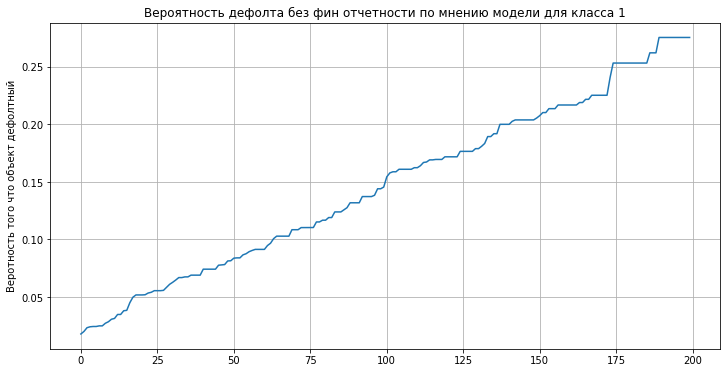

In [ ]:
pred_ip_1 = logreg_ip.predict_proba(X_ip_1)[:,1]
plt.plot(np.arange(200), np.sort(pred_ip_1))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта без фин отчетности по мнению модели для класса 1')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

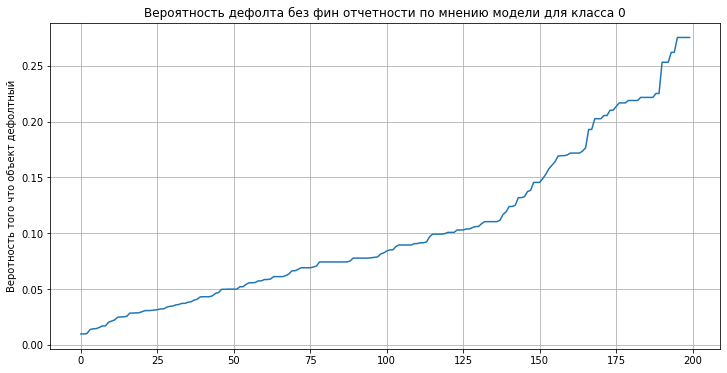

In [ ]:
pred_ip_0 = logreg_ip.predict_proba(X_ip_0)[:,1]
plt.plot(np.arange(200), np.sort(pred_ip_0))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта без фин отчетности по мнению модели для класса 0')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

Вывод: из графиков видно, что модель присваивает бОльшему количеству объектов более низкую вероятность дефолта, если объекты имеют истинный таргет 0(не дефолт). И бОльшему количеству объектов более высокую вероятность дефолта, если объекты имеют истинный таргет 1 (дефолт).

Модель для данных без фин отчетности

In [ ]:
X_phys_with_labels = X_train_woe_phys_final.copy()
X_phys_with_labels['default_12m'] = y_train_woe_phys
X_phys_1 = X_phys_with_labels[X_phys_with_labels['default_12m'] == 1].iloc[:200,]
X_phys_0 = X_phys_with_labels[X_phys_with_labels['default_12m'] == 0].iloc[:200,]
X_phys_1.drop(['default_12m'], axis = 1, inplace = True)
X_phys_0.drop(['default_12m'], axis = 1, inplace = True)

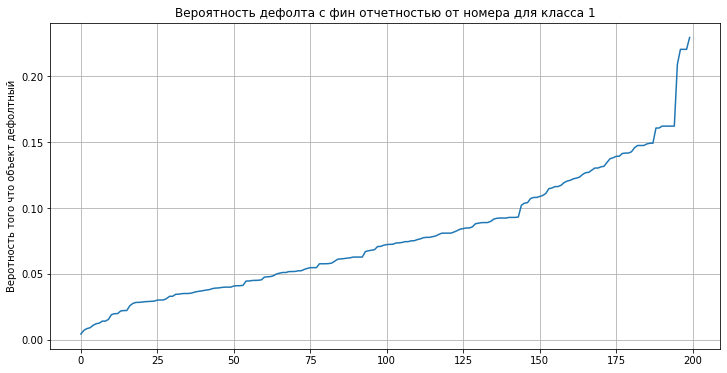

In [ ]:
pred_phys_1 = logreg_phys.predict_proba(X_phys_1)[:,1]
plt.plot(np.arange(200), np.sort(pred_phys_1))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта с фин отчетностью от номера для класса 1')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()

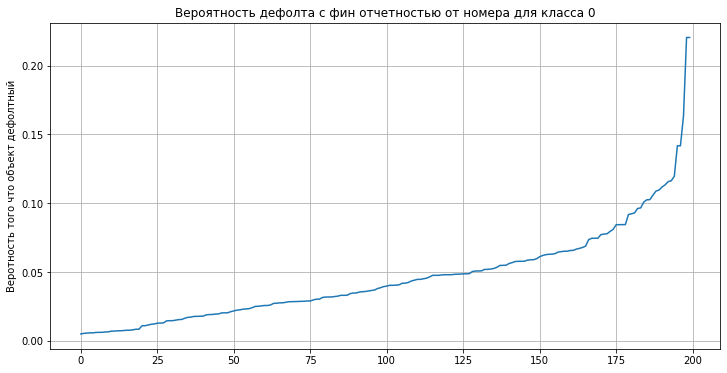

In [ ]:
pred_phys_0 = logreg_phys.predict_proba(X_phys_0)[:,1]
plt.plot(np.arange(200), np.sort(pred_phys_0))
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.title('Вероятность дефолта с фин отчетностью от номера для класса 0')
plt.ylabel('Веротность того что объект дефолтный')
plt.show()